The purpose of this file is to fit a function over a 2D dataset. The function is in fact a product of a Gaussian, a function of $r$, and an activated polynomial of even power, a function of $z$: <br\>
$\qquad \qquad \qquad \qquad \begin{equation}
f(r,z|a,b,c,h,k_1,k_2,p=4) = a\cdot\exp\big(-\frac{(r-0.1)^2}{2c^2}\big)\cdot\sigma(z,b,0.1-h)\cdot\big(1 -\sigma(z,b,0.1+h)\big)\cdot\big((z - 0.1)^p+k_1\big)+k_2
\end{equation}$ <br\>
where $\sigma(z,b,h) = \frac{1}{1 + \exp(-b(x-h))}$. <br\>
Indeed, the parameters can be described as followed:
- $a$: vertical scaling of the entire function
- $b$: sharpness of sigmoid functions
- $c$: standard deviation of the Gaussian
- $h$: vertical translation of the sigmoid functions
- $k$: non-negligeable amount of heat right beside the needle

# Preliminary Function Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn
from numpy.linalg import *

%matplotlib inline

In [2]:
# Function description

def heat_model_func_2D(vert_and_radius, list_para, k2_presence, p=4):
    z, r = vert_and_radius
    if k2_presence:
        a, b, c, h, k1, k2 = list_para
    else:
        a, b, c, h, k1 = list_para
        k2 = 0
    return a*np.exp(-(r-0.1)**2/2/c**2)*sigmoid(z, b, 0.1-h)*(1 - sigmoid(z, b, 0.1+h))*((z-0.1)**p + k1) + k2
    
def sigmoid(z, b, h):
    return 1/(1 + np.exp(-b*(z-h)))

In [3]:
def area_triangle(three_points): # three_points = ((x1, y1), (x2, y2), (x3, y3))
    p1, p2, p3 = three_points
    v1 = np.array(np.subtract(p2, p1)) # tuples cannot be subtracted
    v2 = np.array(np.subtract(p3, p2))
    return np.abs(norm(np.cross(v1, v2))/2)

def middle(three_points): # style is a bit ugly, but very understandeable
    p1, p2, p3 = three_points
    horiz = (p1[0] + p2[0] + p3[0])/3
    vert = (p1[1] + p2[1] + p3[1])/3
    return (horiz, vert)

def scale_indiv(large):
    power = int(np.floor(np.log10(large)))
    scaled_down = 10**(-power)*large    
    return scaled_down, power

def scale(list_para):
    scaled_para = [scale_indiv(para) for para in list_para]
    return list(map(list, zip(*scaled_para))) # returns a list of 

def unscale(scaled_coeff, coeff_power):
    assert len(scaled_coeff) == len(coeff_power)
    return [scaled_coeff[i]*(10**coeff_power[i]) for i in range(len(scaled_coeff))]

# Data Initialization and Visualization

In [4]:
point_data = pd.read_csv('Point Data.csv')
cell_data = pd.read_csv('Cell Data.csv')

Visualization of points before modeling the heat source equation. <br/>
Note that this is the $x=0.111$ plane.

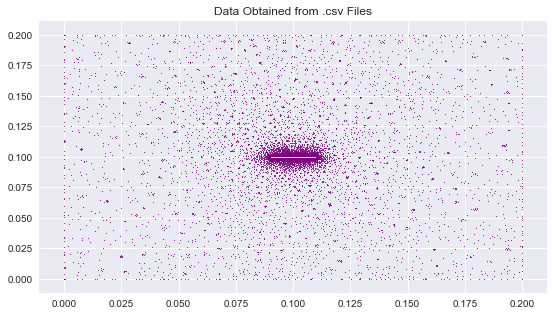

In [5]:
cm = plt.cm.get_cmap('inferno')

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.scatter(point_data['Points:1'], point_data['Points:2'], c='purple', s=0.5)
ax.set_title('Data Obtained from .csv Files')

In [6]:
point_data.head()

,vtkOriginalIndices,Heat[W/m^3],Points:0,Points:1,Points:2,__vtkIsSelected__
0,0,5310000.0,0.111,0.107502,0.101581,0
1,1,5380000.0,0.111,0.107501,0.101571,0
2,2,5380000.0,0.111,0.107485,0.101571,0
3,3,24300000.0,0.111,0.090030,0.101161,0
4,4,9070000.0,0.111,0.089945,0.101358,0


In [7]:
cell_data.head()

,Cell Type,Point Index 0,Point Index 1,Point Index 2,vtkOriginalIndices
0,5,0,1,2,0
1,5,3,4,5,1
2,5,6,7,8,2
3,5,9,10,11,3
4,5,13,14,15,4


# Variable Initialization

### Please note:
In cylindrical coordinates, it is convention to call the vertical variable $z$. However, in the model and in the following lines of code, $y$ will be the vertical variable.

In [8]:
# Variable initialization using Marco's data

heat_source = point_data['Heat[W/m^3]']

# list of tuples: (y, rho)
y_rho = list(zip(point_data['Points:1'], point_data['Points:2']))

# [(386, 387, 388), (389, 390, 391), ...]
points_0 = cell_data['Point Index 0']
points_1 = cell_data['Point Index 1']
points_2 = cell_data['Point Index 2']
index_coords = list(zip(points_0, points_1, points_2))

# list of point coordinates of triangle: [((px1, py1), (px2, py2), (pz1, pz2)), ...]
coords = [tuple(y_rho[j] for j in idx) for idx in index_coords]

mid_points = np.array([middle(c) for c in coords])
mid_point_val = np.array(list(map(lambda tup: (heat_source[tup[0]]+heat_source[tup[1]]+heat_source[tup[2]])/3, index_coords)))

areas = np.array([area_triangle(pts) for pts in coords])

# np.sum(areas) should be 0.2*0.2 - 0.02*0.0016 = 0.039968
assert np.around(np.sum(areas), decimals=6) == np.around(0.2*0.2 - 0.02*0.0016, decimals=6)

# Optimization

Here is the description of input variables:
- ```f``` is the function to be optimized, in this case ```heat_model_func_2D```.
- ```para``` is a list of parameters to be optimized. The number of parameters is flexible, but ```heat_model_func_2D``` has 5 parameters.
- ```x_array``` is a ```numpy.array``` of tuples $(y, \rho)$ at which the function will be evaluated.
- ```f_true``` are data values to which will be used as comparison
- ```areas``` are the weights/areas of every triangle.
- ```k2_bool``` presence of $k_2$ coefficient or not.
- ```past_error``` is used to check if the error stop dropping. If so, then the minimum has been reached. Also, a value of $-1$ indicates the first iteration in the recursion.

In [9]:
# Hashtagged print statements are kept in case debugging is needed, again

def opt_para_2D(f, para, x_array, f_true, areas, k2_bool, tolerance, past_error=-1):
    # Note: para is a tuple, scaling is done before calling opt_para_2D
    # by setting past_error = -1, can tell when the function is ran for the first time
    
    assert len(x_array) == len(f_true)
    assert all(len(point) == 2 for point in x_array)
    
    smaller_max, power_max = scale_indiv(max(f_true))
    
    new_guess, para_powers = para

    def max_function(list_para):
        scaled_guesses = unscale(list_para, para_powers)
        # Line above makes sure that optimization is run on the coefficient of scientific notation
        # as long as max_function is a function of the coefficients of the parameters
        # i.e. the optimization algorithm will optimize 3 and not 3e7
        
        f_est = np.array([f(y_rho_coords, scaled_guesses, k2_bool) for y_rho_coords in x_array])
        
        # smaller value of the overall loss function (~x1e-7)
        return np.square(f_est - f_true)@areas*10**(-power_max)
    
    xopt, fopt, gopt, Bopt, func_calls, grad_calls, warning = opt.fmin_bfgs(max_function, new_guess, full_output=True)
    # xopt, fopt, gopt, Bopt, func_calls, grad_calls, warning should be used in case
    # other evaluated values, such as gradient of function value, are to be checked
    
    error = max_function(xopt)
    assert error > 0
    print()
    
#    print("xopt before: ", xopt)
    
    list_xopt = list(xopt) # xopt is a np.array

    print("xopt after: ", xopt)
    
    if np.abs((error - past_error)/past_error) < tolerance:
        return list_xopt
        
    elif error > tolerance or past_error==-1:
        return opt_para_2D(f, (list_xopt, para_powers), x_array, f_true, areas, k2_bool, tolerance, error)
        
    else:
        return list_xopt

### Initial Guesses

Reminder: ```initial_guess = [a, b, c, h, k1, k2]```. <br/>
Here are the magnitudes of every variables: $a\sim10^{14}, b\sim10^3, c\sim10^{-3}, h\sim10^{-2}, k_1\sim10^{-9}, k_2\sim10^3$.

In [10]:
a_init = 1e15
b_init = 1e3
c_init = 1e-3
h_init = 1e-2
k1_init = 1e-9
k2_init = 1 # setting k2_init as 0 will yield an error
para_name_str = ['a', 'b', 'c', 'h', 'k1', 'k2'] # for printing in a human friendly format

init_guess_with_k2 = [a_init, b_init, c_init, h_init, k1_init, k2_init] # reminder: [a, b, c, h, k]
input_tup_with_k2 = scale(init_guess_with_k2) # [(1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (14, 3, -3, -2, -9, 2)] for instance
init_guess_without_k2 = [a_init, b_init, c_init, h_init, k1_init]
input_tup_without_k2 = scale(init_guess_without_k2)
# copy pasting of code due to issue with the data structure

# Results 

In [11]:
result_with_k2 = opt_para_2D(heat_model_func_2D, input_tup_with_k2, mid_points, mid_point_val, \
                             areas, True, 1)
result_without_k2 = opt_para_2D(heat_model_func_2D, input_tup_without_k2, mid_points, mid_point_val, \
                                  areas, False, 1)
# only difference is a True or False and initial guess

print("After optimization, values of every parameter in optimal solution:")
print("Non-zero k2:")
for i in range(len(result_with_k2)):
    print("{}: {}e{}".format(para_name_str[i], result_with_k2[i], input_tup_with_k2[1][i]))
print("")
print("k2 set as 0:")
for i in range(len(result_without_k2)):
    print("{}: {}e{}".format(para_name_str[i], result_without_k2[i], input_tup_without_k2[1][i]))
print("k2: 0")

         Current function value: 56.472967
         Iterations: 69
         Function evaluations: 737
         Gradient evaluations: 92

xopt after:  [  1.83609294e+00   3.09060482e+00   1.12082021e+00   1.02918334e+00
   7.22591606e+00   7.17410348e+03]
         Current function value: 56.472967
         Iterations: 8
         Function evaluations: 396
         Gradient evaluations: 48

xopt after:  [  1.83609784e+00   3.09060533e+00   1.12081946e+00   1.02918325e+00
   7.22590503e+00   7.17410348e+03]
Optimization terminated successfully.
         Current function value: 56.677497
         Iterations: 37
         Function evaluations: 336
         Gradient evaluations: 48

xopt after:  [ 1.83371248  3.0853594   1.12200957  1.02924952  7.23387586]
Optimization terminated successfully.
         Current function value: 56.677497
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1

xopt after:  [ 1.83371248  3.0853594   1.12200957  1.02924952  7.23387

### Visualization of Optimized Results
Plot below is with the modeled heat source in colour. <br/>
Set $k_2 = 0$.

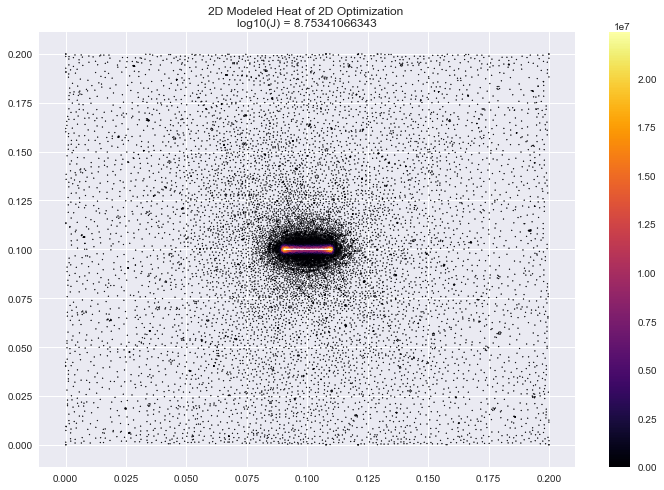

In [12]:
# colour_with_k2 = [heat_model_func_2D(tup, unscale(result_with_k2, input_tup_with_k2[1]), True) for tup in mid_points]
colour_without_k2 = [heat_model_func_2D(tup, unscale(result_without_k2, input_tup_without_k2[1]), False) for tup in mid_points]

error_2D = np.square(colour_without_k2 - mid_point_val)@areas

fig = plt.figure(figsize=(12, 8))
plt.scatter(mid_points.T[0], mid_points.T[1], c=colour_without_k2,  s=1, cmap = cm)
plt.title("2D Modeled Heat of 2D Optimization \nlog10(J) = " + str(np.log10(error_2D)))
plt.savefig("2D_Fitting_2D_opt.eps")
plt.colorbar()

Indeed, from the images above, it seems that $k_2$ can be set equal to $0$. If so, other variable values will be adjusted, especially $k_1$, such that the error value is still similar.